#Cas d'usage: Planification du raccordement électrique de bâtiments

##Contexte

Une petite ville a été touchée par des intempéries, entraînant la destruction de plusieurs infrastructures permettant le raccordement des maisons au réseau électrique. Vous avez été embauché par la mairie afin de proposer une planification pour les travaux à effectuer, dans le but de re-raccorder tous les citoyens à la fibre. L'objectif est de rétablir rapidement la connexion pour le plus grand nombre d'habitants avec le budget le plus faible possible
Vous avez été fournis avec deux shapefiles et un fichier CSV. Ces fichiers représentent respectivement les bâtiments, les lignes électriques à déployer pour le raccordement, et l'arbre linéaire du réseau qui décrit les connexions à mettre en œuvre et les coûts de raccordement.
Toutes l’information dont vous avez besoin pour proposer votre planification se situe dans le fichier “reseau_en_arbre.csv”


##Objectifs du Cas d'Utilisation

Votre mission est de créer un plan de raccordement qui priorise les bâtiments les plus simples à raccorder (en minimisant les coûts) tout en maximisant le nombre de prises raccordées. Vous devrez prendre en compte la mutualisation des lignes électriques entre plusieurs bâtiments pour optimiser le plan.

##Données Fournies

Shapefile des Bâtiments: Contient les données géospatiales des bâtiments, y compris leurs emplacements.
Shapefile des Lignes Électriques: Contient les données géospatiales des lignes électriques à déployer pour le raccordement.
Fichier CSV de l'Arbre Linéaire: Fournit une représentation linéaire du réseau, indiquant les connexions et les coûts de raccordement.

##Instructions

###1. Analyse Préliminaire

In [186]:
## Imports

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import networkx as nx
from pathlib import Path
from collections import defaultdict

# Configuration des graphiques
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

In [187]:
def analyser_shapefiles():
    print("=" * 60)
    print("1. ANALYSE DES SHAPEFILES")
    print("=" * 60)

    try:
        # Chargement des shapefiles
        batiments_gdf = gpd.read_file('batiments.shp')
        infrastructures_gdf = gpd.read_file('infrastructures.shp')
        print()

        # Analyse des bâtiments
        print("ANALYSE DES BÂTIMENTS")
        print("-" * 30)
        print(f"Nombre total de bâtiments : {len(batiments_gdf)}")
        print(f"Système de coordonnées : {batiments_gdf.crs}")
        print(f"Colonnes disponibles : {list(batiments_gdf.columns)}")
        print(batiments_gdf.head())
        print()

        # Statistiques des bâtiments
        print("Statistiques des bâtiments :")
        batiments_stats = batiments_gdf.groupby('nb_maisons').size()
        for nb_maisons, count in batiments_stats.items():
            print(f"  - {count} bâtiments avec {nb_maisons} maison(s)")
        print()

        # Analyse des infrastructures
        print("ANALYSE DES INFRASTRUCTURES ÉLECTRIQUES")
        print("-" * 45)
        print(f"Nombre total d'infrastructures : {len(infrastructures_gdf)}")
        print(f"Système de coordonnées : {infrastructures_gdf.crs}")
        print(f"Colonnes disponibles : {list(infrastructures_gdf.columns)}")
        print(infrastructures_gdf.head())
        print()

        # Visualisation géographique
        print("VISUALISATION GÉOGRAPHIQUE")
        print("-" * 35)

        fig, axes = plt.subplots(1, 2, figsize=(20, 8))

        # Carte des bâtiments
        batiments_gdf.plot(ax=axes[0], color='lightblue', alpha=0.7, edgecolor='navy')
        axes[0].set_title('Disposition géographique des bâtiments')
        axes[0].set_xlabel('Longitude')
        axes[0].set_ylabel('Latitude')

        # Carte des infrastructures
        infrastructures_gdf.plot(ax=axes[1], color='orange', linewidth=2, alpha=0.8)
        axes[1].set_title('Réseau électrique existant')
        axes[1].set_xlabel('Longitude')
        axes[1].set_ylabel('Latitude')

        plt.tight_layout()
        plt.savefig('analyse_shapefiles.png', dpi=300, bbox_inches='tight')
        plt.show()

        print("Carte sauvegardée : 'analyse_shapefiles.png'")
        print()

        return batiments_gdf, infrastructures_gdf

    except Exception as e:
        print(f"Erreur lors du chargement des shapefiles : {e}")
        return None, None

1. ANALYSE DES SHAPEFILES

ANALYSE DES BÂTIMENTS
------------------------------
Nombre total de bâtiments : 381
Système de coordonnées : EPSG:27700
Colonnes disponibles : ['id_bat', 'nb_maisons', 'geometry']
    id_bat  nb_maisons                       geometry
0  E000270         1.0  POINT (531436.652 259655.507)
1  E000010         1.0  POINT (531445.663 259480.504)
2  E000060         1.0  POINT (531529.658 259588.506)
3  E000200         1.0  POINT (531217.642 259637.504)
4  E000249         1.0  POINT (531369.649 259611.505)

Statistiques des bâtiments :
  - 378 bâtiments avec 1.0 maison(s)
  - 1 bâtiments avec 3.0 maison(s)
  - 2 bâtiments avec 4.0 maison(s)

ANALYSE DES INFRASTRUCTURES ÉLECTRIQUES
---------------------------------------------
Nombre total d'infrastructures : 644
Système de coordonnées : EPSG:27700
Colonnes disponibles : ['infra_id', 'longueur', 'geometry']
  infra_id   longueur                                           geometry
0  P007320   5.495148  LINESTRING (531

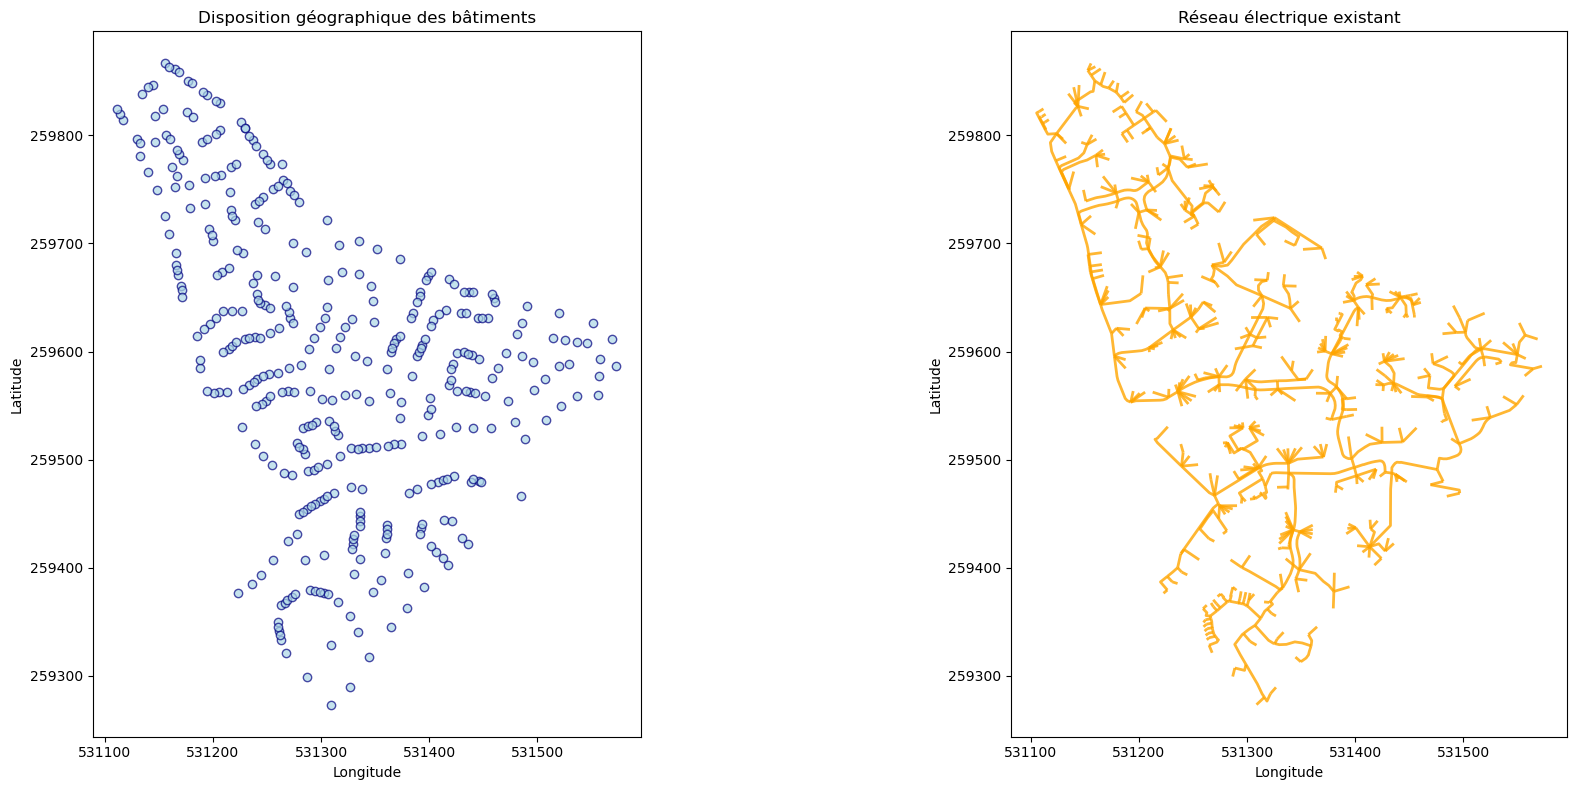

Carte sauvegardée : 'analyse_shapefiles.png'



In [188]:
batiments_gdf, infrastructures_gdf = analyser_shapefiles()

In [189]:
def analyser_csv():
   
    print("2. ANALYSE DU FICHIER CSV")
    print("=" * 60)

    try:
        # Chargement du fichier Excel
        df = pd.read_excel('reseau_en_arbre.xlsx')

        print("Fichier Excel chargé avec succès")
        print()

        # Statistiques générales
        print("STATISTIQUES GÉNÉRALES")
        print("-" * 25)
        print(f"Nombre total d'enregistrements : {len(df)}")
        print(f"Nombre de bâtiments uniques : {df['id_batiment'].nunique()}")
        print(f"Nombre d'infrastructures uniques : {df['infra_id'].nunique()}")
        print()

        # Structure des données
        print("STRUCTURE DES DONNÉES")
        print("-" * 25)
        print("Colonnes disponibles :")
        for col in df.columns:
            print(f"  - {col}")
        print()

        # Analyse par type d'infrastructure
        print("ANALYSE PAR TYPE D'INFRASTRUCTURE")
        print("-" * 40)

        infra_stats = df.groupby('infra_type').agg({
            'longueur': ['count', 'sum', 'mean', 'min', 'max'],
            'id_batiment': 'nunique'
        }).round(2)

        print("Statistiques par type d'infrastructure :")
        print(infra_stats)
        print()

        # Analyse par bâtiment
        print("ANALYSE PAR BÂTIMENT")
        print("-" * 25)

        batiment_stats = df.groupby('id_batiment').agg({
            'nb_maisons': 'first',
            'longueur': ['count', 'sum'],
            'infra_type': lambda x: (x == 'a_remplacer').sum()
        }).round(2)

        batiment_stats.columns = ['nb_maisons', 'nb_segments', 'longueur_totale', 'nb_a_remplacer']

        print("Top 10 bâtiments par longueur totale :")
        top_10 = batiment_stats.nlargest(10, 'longueur_totale')
        for idx, row in top_10.iterrows():
            print(f"  {idx}: {row['longueur_totale']:.2f}m total, {int(row['nb_maisons'])} maison(s), {int(row['nb_segments'])} segments")
        print()

        # Analyse des coûts totaux
        print("ANALYSE DES COÛTS")
        print("-" * 20)

        total_longueur_intacte = df[df['infra_type'] == 'infra_intacte']['longueur'].sum()
        total_longueur_remplacer = df[df['infra_type'] == 'a_remplacer']['longueur'].sum()
        total_maisons = df.groupby('id_batiment')['nb_maisons'].first().sum()

        print(f"Longueur totale infrastructures intactes : {total_longueur_intacte:.2f} m")
        print(f"Longueur totale à remplacer : {total_longueur_remplacer:.2f} m")
        print(f"Total maisons à raccorder : {total_maisons}")
        print(f"Coût estimé total (longueur à remplacer) : {total_longueur_remplacer:.2f} m")
        print()

        # Analyse de la mutualisation
        print("ANALYSE DE LA MUTUALISATION")
        print("-" * 30)

        infra_connexions = df.groupby('infra_id').agg({
            'id_batiment': list,
            'longueur': 'first',
            'infra_type': 'first'
        }).reset_index()

        # Infrastructures mutualisées (partagées par plusieurs bâtiments)
        infra_mutualisees = infra_connexions[infra_connexions['id_batiment'].apply(len) > 1]

        print(f"Infrastructures mutualisées : {len(infra_mutualisees)}/{len(infra_connexions)} ({len(infra_mutualisees)/len(infra_connexions)*100:.1f}%)")
        print(f"Longueur mutualisée : {infra_mutualisees['longueur'].sum():.2f} m")

        # Distribution du nombre de bâtiments par infrastructure
        mutualisation_dist = infra_mutualisees['id_batiment'].apply(len).value_counts().sort_index()
        print("Distribution de la mutualisation :")
        for nb_batiments, count in mutualisation_dist.items():
            print(f"  - {count} infrastructures partagées par {nb_batiments} bâtiments")
        print()

        # Graphiques d'analyse
        print("VISUALISATIONS STATISTIQUES")
        print("-" * 35)

        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Analyse du réseau électrique - Statistiques générales', fontsize=16)

        # 1. Distribution des types d'infrastructure
        infra_counts = df['infra_type'].value_counts()
        axes[0,0].pie(infra_counts.values, labels=infra_counts.index, autopct='%1.1f%%')
        axes[0,0].set_title('Répartition des types d\'infrastructure')

        # 2. Distribution des longueurs par type
        sns.boxplot(data=df, x='infra_type', y='longueur', ax=axes[0,1])
        axes[0,1].set_title('Distribution des longueurs par type d\'infrastructure')
        axes[0,1].set_ylabel('Longueur (m)')

        # 3. Nombre de maisons par bâtiment
        maisons_dist = df.groupby('id_batiment')['nb_maisons'].first().value_counts().sort_index()
        axes[1,0].bar(maisons_dist.index, maisons_dist.values)
        axes[1,0].set_title('Distribution du nombre de maisons par bâtiment')
        axes[1,0].set_xlabel('Nombre de maisons')
        axes[1,0].set_ylabel('Nombre de bâtiments')

        # 4. Top 10 bâtiments par longueur
        top_10_plot = batiment_stats.nlargest(10, 'longueur_totale')
        axes[1,1].bar(range(len(top_10_plot)), top_10_plot['longueur_totale'])
        axes[1,1].set_title('Top 10 bâtiments par longueur totale de réseau')
        axes[1,1].set_xlabel('Bâtiment (index)')
        axes[1,1].set_ylabel('Longueur totale (m)')
        axes[1,1].set_xticks(range(len(top_10_plot)))
        axes[1,1].set_xticklabels([f'E{i+1}' for i in range(len(top_10_plot))], rotation=45)

        plt.tight_layout()
        plt.savefig('analyse_csv.png', dpi=300, bbox_inches='tight')
        plt.show()

        print("Graphiques sauvegardés : 'analyse_csv.png'")
        print()

        return df

    except Exception as e:
        print(f"Erreur lors du chargement du fichier CSV : {e}")
        return None


2. ANALYSE DU FICHIER CSV
Fichier Excel chargé avec succès

STATISTIQUES GÉNÉRALES
-------------------------
Nombre total d'enregistrements : 6107
Nombre de bâtiments uniques : 381
Nombre d'infrastructures uniques : 644

STRUCTURE DES DONNÉES
-------------------------
Colonnes disponibles :
  - id_batiment
  - nb_maisons
  - infra_id
  - infra_type
  - longueur

ANALYSE PAR TYPE D'INFRASTRUCTURE
----------------------------------------
Statistiques par type d'infrastructure :
              longueur                                id_batiment
                 count        sum   mean   min    max     nunique
infra_type                                                       
a_remplacer        577    5578.31   9.67  0.37  42.11          85
infra_intacte     5530  173442.78  31.36  1.10  76.99         381

ANALYSE PAR BÂTIMENT
-------------------------
Top 10 bâtiments par longueur totale :
  E000362: 810.14m total, 1 maison(s), 25 segments
  E000340: 807.55m total, 1 maison(s), 24 segments


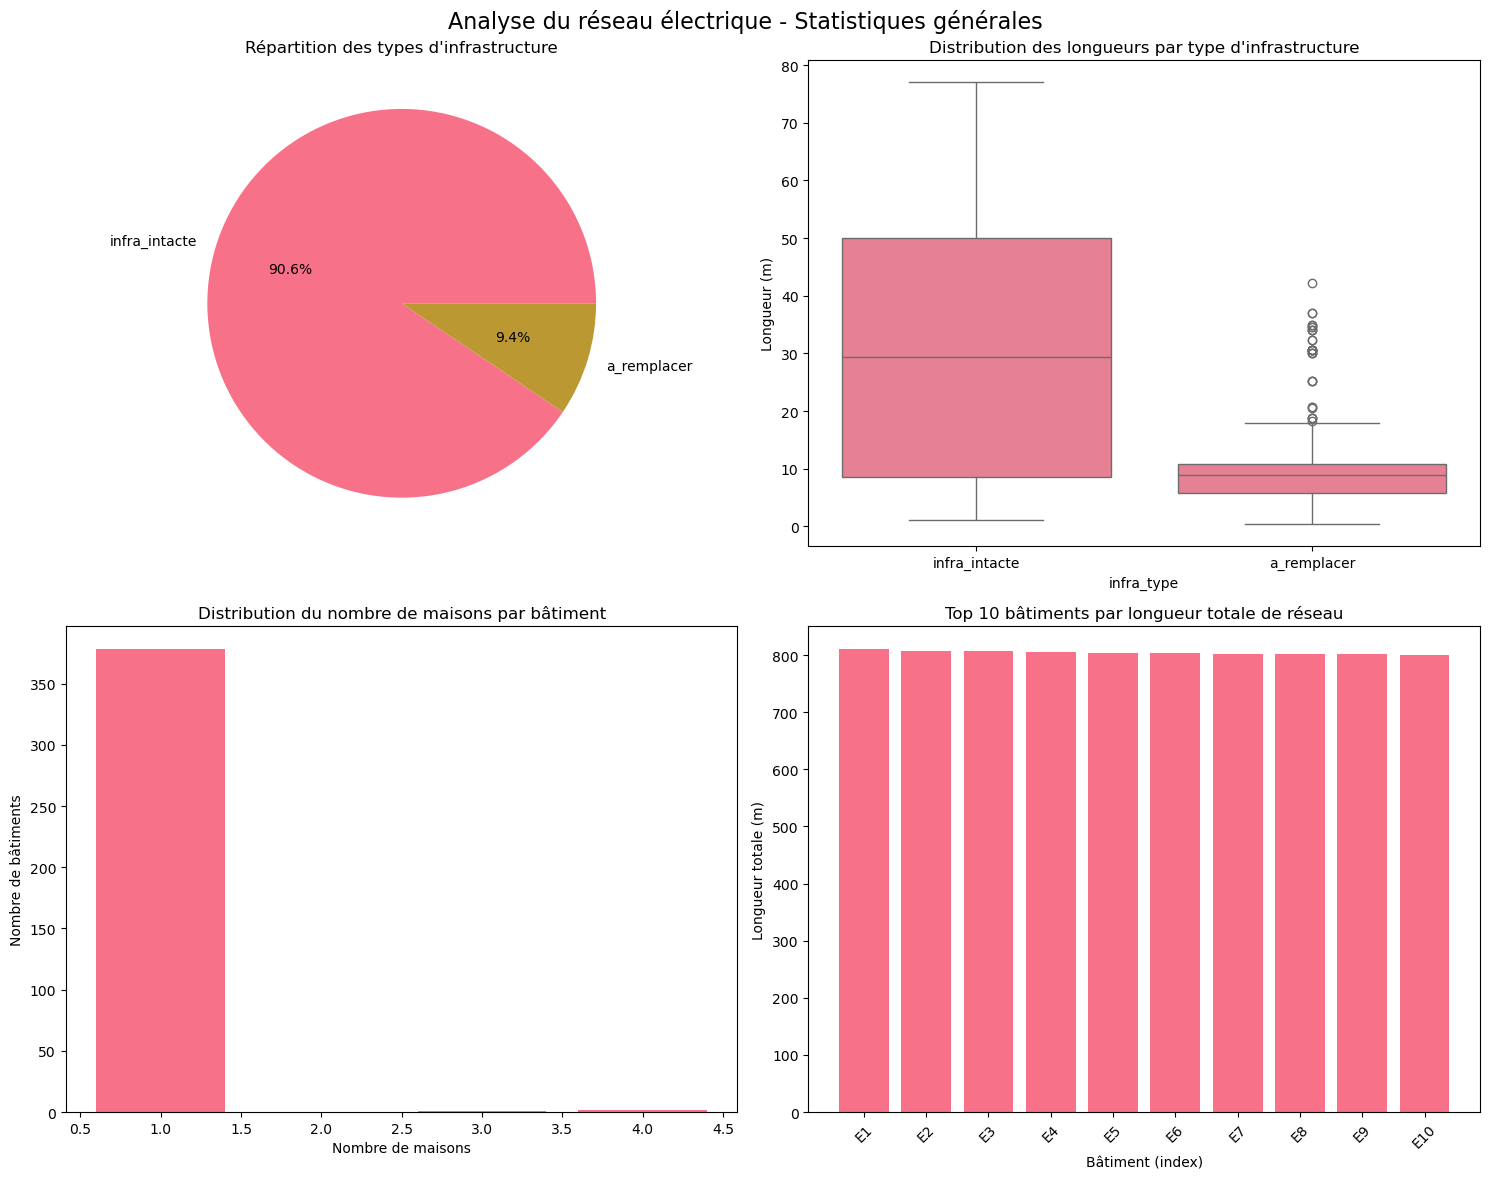

Graphiques sauvegardés : 'analyse_csv.png'



In [190]:
df = analyser_csv()

In [191]:
def visualiser_reseau_fusionne(batiments_gdf, infrastructures_gdf, df_csv):
    print("=" * 60)
    print("3. VISUALISATION DU RÉSEAU FUSIONNÉ")
    print("=" * 60)

    try:
        # Vérifier les colonnes clés
        if 'infra_id' not in infrastructures_gdf.columns or 'infra_id' not in df_csv.columns:
            raise ValueError("Colonne 'infra_id' manquante dans les données !")

        # Fusionner les shapefiles d'infrastructures avec le CSV
        infra_merged = infrastructures_gdf.merge(
            df_csv[['infra_id', 'infra_type', 'id_batiment']],
            on='infra_id',
            how='left'
        )

        print(f"Fusion réussie : {len(infra_merged)} enregistrements après jointure")

        # Vérifier la présence des types d'infrastructure
        print(infra_merged['infra_type'].value_counts(dropna=False))
        print()

        # Création de la carte
        fig, ax = plt.subplots(1, 1, figsize=(12, 10))
        ax.set_title("Réseau de raccordement : infrastructures et bâtiments")

        # Tracer les infrastructures intactes (vert)
        infra_intacte = infra_merged[infra_merged['infra_type'] == 'infra_intacte']
        if not infra_intacte.empty:
            infra_intacte.plot(ax=ax, color='green', linewidth=2, label='Infrastructures intactes')

        # Tracer les infrastructures à remplacer (rouge)
        infra_a_remplacer = infra_merged[infra_merged['infra_type'] == 'a_remplacer']
        if not infra_a_remplacer.empty:
            infra_a_remplacer.plot(ax=ax, color='red', linewidth=2, label='À remplacer')

        # Tracer les bâtiments
        batiments_gdf.plot(ax=ax, color='lightblue', alpha=0.6, edgecolor='navy', label='Bâtiments')

        # Mise en forme
        ax.legend()
        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")

        plt.tight_layout()
        plt.savefig('reseau_fusionne.png', dpi=300, bbox_inches='tight')
        plt.show()

        print("Carte fusionnée sauvegardée : 'reseau_fusionne.png'")
        print()

        return infra_merged

    except Exception as e:
        print(f"Erreur lors de la fusion ou de la visualisation : {e}")
        return None


3. VISUALISATION DU RÉSEAU FUSIONNÉ
Fusion réussie : 6107 enregistrements après jointure
infra_type
infra_intacte    5530
a_remplacer       577
Name: count, dtype: int64



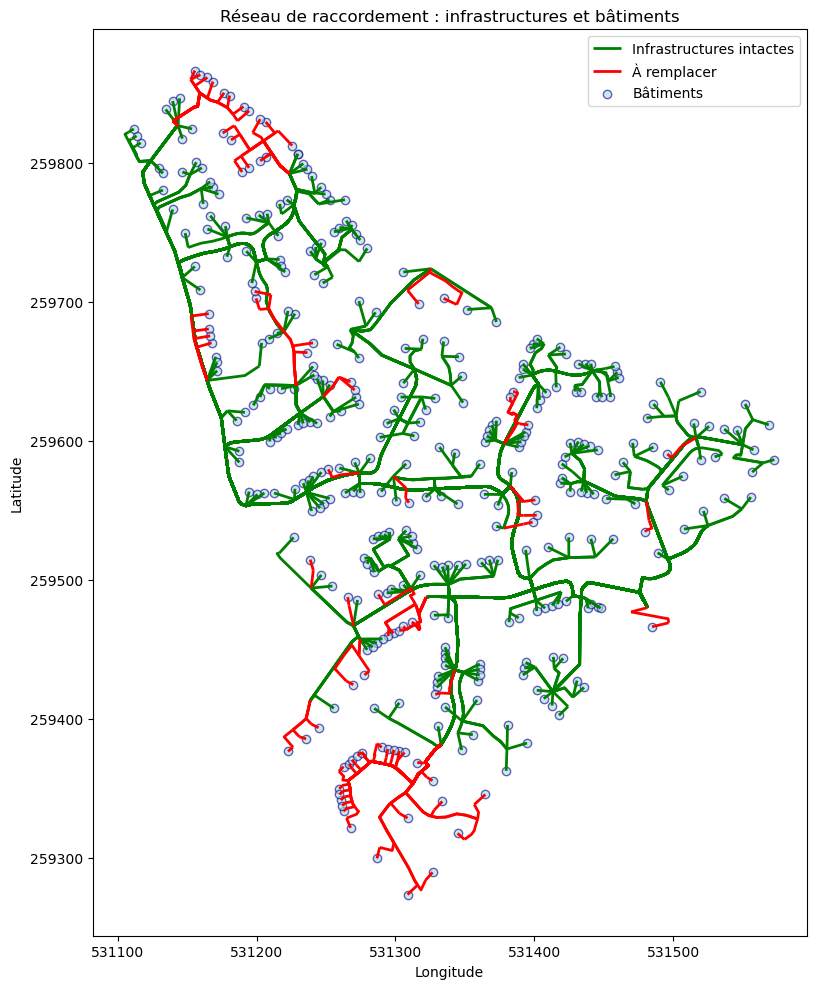

Carte fusionnée sauvegardée : 'reseau_fusionne.png'



In [192]:
infra_merged = visualiser_reseau_fusionne(batiments_gdf, infrastructures_gdf, df)

###2. Modélisation du Réseau

In [193]:
## Modélisez le réseau électrique en utilisant la théorie des graphes, où les bâtiments sont des nœuds et les lignes électriques sont des arêtes.
## Intégrez les données de coût dans les arêtes de votre modèle de graphe.

def modeliser_reseau(df_csv):
    print("=" * 60)
    print("4. MODÉLISATION DU RÉSEAU ÉLECTRIQUE (GRAPHE)")
    print("=" * 60)

    try:
        # Création du graphe non orienté
        G = nx.Graph()

        # --- Étape 1 : Ajouter les nœuds (bâtiments)
        batiments = df_csv['id_batiment'].unique()
        for bat in batiments:
            nb_maisons = df_csv.loc[df_csv['id_batiment'] == bat, 'nb_maisons'].iloc[0]
            G.add_node(bat, nb_maisons=nb_maisons)
        print(f"Nœuds ajoutés : {len(G.nodes)} bâtiments")

        # --- Étape 2 : Ajouter les arêtes (infrastructures)
        for _, row in df_csv.iterrows():
            infra_id = row['infra_id']
            infra_type = row['infra_type']
            longueur = row['longueur']
            id_batiment = row['id_batiment']

            # Définition d’un coût (pondération)
            if infra_type == 'a_remplacer':
                cout = longueur * 1.0  # tu peux définir un vrai barème ici
            elif infra_type == 'infra_intacte':
                cout = longueur * 0.2
            else:
                cout = longueur * 0.5  # par défaut

            # Ajouter une arête entre le bâtiment et l’infrastructure virtuelle
            G.add_edge(f"infra_{infra_id}", f"bat_{id_batiment}",
                       infra_id=infra_id,
                       infra_type=infra_type,
                       longueur=longueur,
                       cout=cout)

        print(f"Arêtes ajoutées : {len(G.edges)} connexions")

        # --- Étape 3 : Statistiques de connectivité
        print("\nSTATISTIQUES DU GRAPHE")
        print("-" * 30)
        print(f"Composantes connexes : {nx.number_connected_components(G)}")
        print(f"Degré moyen : {sum(dict(G.degree()).values()) / len(G.nodes):.2f}")

        # --- Étape 4 : Visualisation rapide du graphe
        plt.figure(figsize=(10, 8))
        pos = nx.spring_layout(G, seed=42, k=0.3)

        # Couleur selon type d’infra
        edge_colors = [
            'red' if G[u][v]['infra_type'] == 'a_remplacer' else 'green'
            for u, v in G.edges
        ]

        nx.draw(
            G,
            pos,
            node_size=80,
            node_color='skyblue',
            edge_color=edge_colors,
            with_labels=False,
            alpha=0.7
        )
        plt.title("Modélisation du réseau électrique (graphe)")
        plt.tight_layout()
        plt.savefig("graphe_reseau.png", dpi=300, bbox_inches='tight')
        plt.show()

        print("Graphe sauvegardé : 'graphe_reseau.png'")
        print()

        return G

    except Exception as e:
        print(f"Erreur lors de la modélisation du réseau : {e}")
        return None



4. MODÉLISATION DU RÉSEAU ÉLECTRIQUE (GRAPHE)
Nœuds ajoutés : 381 bâtiments
Arêtes ajoutées : 5586 connexions

STATISTIQUES DU GRAPHE
------------------------------
Composantes connexes : 382
Degré moyen : 7.95


C:\Users\kadia\AppData\Local\Temp\ipykernel_21228\2024311398.py:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


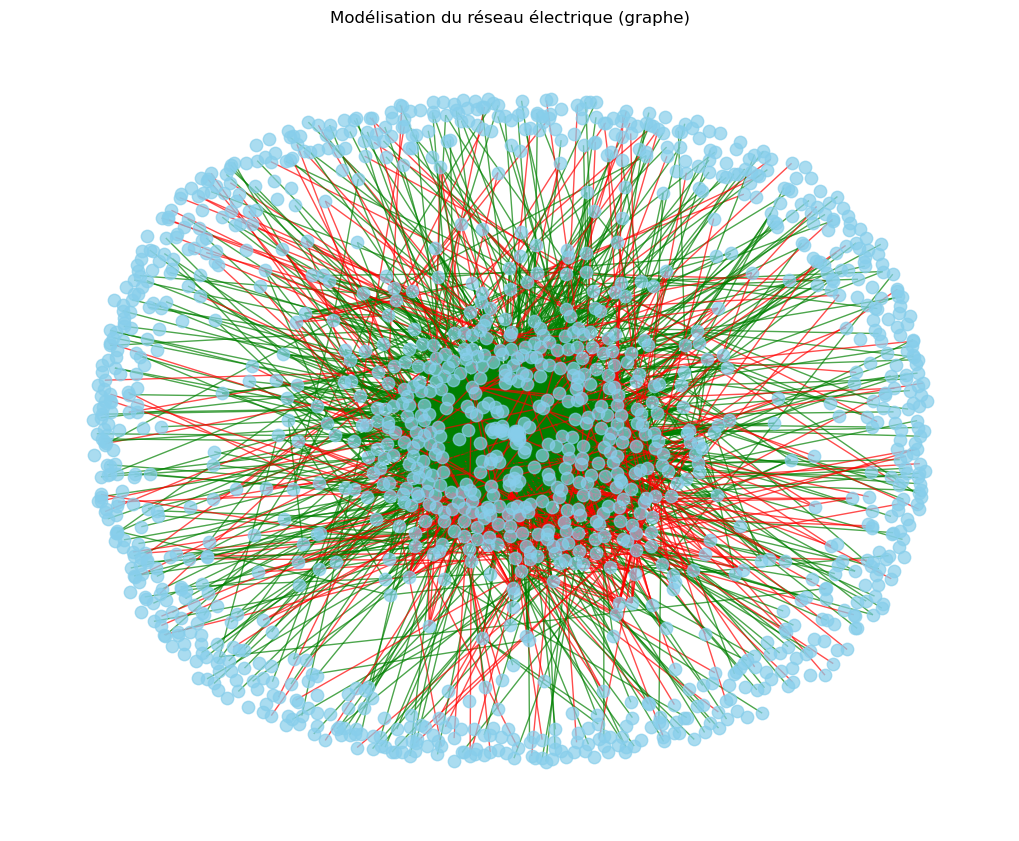

Graphe sauvegardé : 'graphe_reseau.png'



In [194]:
G = modeliser_reseau(df)

In [195]:
df_reparer = df[df['infra_type'] == 'a_remplacer'].copy()
df_reparer.count()


id_batiment    577
nb_maisons     577
infra_id       577
infra_type     577
longueur       577
dtype: int64

In [196]:
df_reparer = df_reparer.drop_duplicates(subset=['id_batiment', 'infra_id']).reset_index(drop=True)
# df_reparer.count()
df_reparer.head()

,id_batiment,nb_maisons,infra_id,infra_type,longueur
0,E000003,1,P007113,a_remplacer,12.193509
1,E000003,1,P007984,a_remplacer,30.057598
2,E000003,1,P007823,a_remplacer,12.290283
3,E000067,1,P006193,a_remplacer,12.186388
4,E000067,1,P002851,a_remplacer,10.803202


In [197]:
# Nombre de bâtiments desservis par chaque infra
nb_batiments_par_infra = df_reparer.groupby('infra_id')['id_batiment'].nunique()
df_reparer = df_reparer.merge(nb_batiments_par_infra.rename('nb_batiments'), on='infra_id')
df_reparer['difficulte_infra'] = df_reparer['longueur'] / df_reparer['nb_maisons']


In [198]:
nb_batiments_par_infra.head()
df_reparer.head()
df_reparer['difficulte_infra'].head()

0    12.193509
1    30.057598
2    12.290283
3    12.186388
4    10.803202
Name: difficulte_infra, dtype: float64

In [202]:
difficulte_batiments = (
    df_reparer.groupby('id_batiment')['difficulte_infra']
    .sum()
    .reset_index()
    .rename(columns={'difficulte_infra': 'difficulte_batiment'})
)
difficulte_batiments.head()

,id_batiment,difficulte_batiment
0,E000003,54.541389
1,E000067,27.099494
2,E000085,34.690247
3,E000098,20.982113
4,E000106,42.609184


###3. Développement de la Métrique de Priorisation

###4. Planification du Raccordement

In [203]:
## Utilisez votre métrique pour établir un ordre de priorité pour le raccordement des bâtiments.
## Proposez un plan d'action qui détaille l'ordre dans lequel les bâtiments doivent être raccordés.
def planifier_reparations(df_csv, difficulte_batiments):
    print("5. PLANIFICATION DES RÉPARATIONS")
    print("=" * 60)

    # Identifier les bâtiments à réparer et ceux déjà intacts
    batiments_intacts = df_csv[df_csv['infra_type'] != 'a_remplacer']['id_batiment'].unique()
    batiments_a_reparer = difficulte_batiments['id_batiment'].unique().tolist()

    print(f"{len(batiments_intacts)} bâtiments en phase 0 (aucune réparation nécessaire)")
    print(f"{len(batiments_a_reparer)} bâtiments nécessitent des réparations\n")

    # Initialisation
    plan = []  # liste finale des réparations
    phase = 1

    # Convertir en dictionnaire pour accès rapide
    difficulte_dict = dict(zip(difficulte_batiments['id_batiment'],
                               difficulte_batiments['difficulte_batiment']))

    # Boucle itérative : tant qu’il reste des bâtiments à réparer
    while batiments_a_reparer:
        # Récupérer le bâtiment le moins difficile
        batiment_min = min(batiments_a_reparer, key=lambda b: difficulte_dict[b])
        difficulte_min = difficulte_dict[batiment_min]

        # Ajouter au plan
        plan.append({
            'phase': phase,
            'id_batiment': batiment_min,
            'difficulte_batiment': difficulte_min
        })

        print(f"Phase {phase}: Réparation du bâtiment {batiment_min} (difficulté = {difficulte_min:.2f})")

        # Réparer ses infrastructures (ici on simule)
        infra_associees = df_csv.loc[df_csv['id_batiment'] == batiment_min, 'infra_id'].unique()

        # Mettre à jour le CSV pour marquer les infrastructures comme réparées
        df_csv.loc[df_csv['infra_id'].isin(infra_associees), 'infra_type'] = 'infra_intacte'

        # Retirer le bâtiment de la liste à réparer
        batiments_a_reparer.remove(batiment_min)

        # Incrémenter la phase
        phase += 1

    print("\nPlanification terminée : tous les bâtiments sont réparés.")
    return pd.DataFrame(plan), df_csv


In [204]:
plan_reparation, df_csv = planifier_reparations(df, difficulte_batiments)

5. PLANIFICATION DES RÉPARATIONS
381 bâtiments en phase 0 (aucune réparation nécessaire)
85 bâtiments nécessitent des réparations

Phase 1: Réparation du bâtiment E000112 (difficulté = 20.89)
Phase 2: Réparation du bâtiment E000098 (difficulté = 20.98)
Phase 3: Réparation du bâtiment E000274 (difficulté = 21.16)
Phase 4: Réparation du bâtiment E000222 (difficulté = 23.11)
Phase 5: Réparation du bâtiment E000188 (difficulté = 23.90)
Phase 6: Réparation du bâtiment E000127 (difficulté = 24.58)
Phase 7: Réparation du bâtiment E000364 (difficulté = 24.72)
Phase 8: Réparation du bâtiment E000111 (difficulté = 25.75)
Phase 9: Réparation du bâtiment E000185 (difficulté = 26.28)
Phase 10: Réparation du bâtiment E000267 (difficulté = 27.04)
Phase 11: Réparation du bâtiment E000067 (difficulté = 27.10)
Phase 12: Réparation du bâtiment E000301 (difficulté = 28.52)
Phase 13: Réparation du bâtiment E000365 (difficulté = 29.71)
Phase 14: Réparation du bâtiment E000128 (difficulté = 30.01)
Phase 15: 

In [206]:
df_csv.head(20)

,id_batiment,nb_maisons,infra_id,infra_type,longueur
0,E000001,4,P007111,infra_intacte,12.314461
1,E000001,4,P007983,infra_intacte,40.320929
2,E000001,4,P000308,infra_intacte,39.140799
3,E000001,4,P007819,infra_intacte,17.390464
4,E000002,1,P007111,infra_intacte,12.314461
5,E000002,1,P007983,infra_intacte,40.320929
6,E000002,1,P000308,infra_intacte,39.140799
7,E000002,1,P007240,infra_intacte,10.914626
8,E000003,1,P007111,infra_intacte,12.314461
9,E000003,1,P007111,infra_intacte,12.314461


###5. Optimisation

In [157]:
## Identifiez les opportunités de mutualisation des lignes pour réduire les coûts.
##Ajustez votre plan pour maximiser le nombre de prises raccordées


3. VISUALISATION DU RÉSEAU FUSIONNÉ
Fusion réussie : 6107 enregistrements après jointure
infra_type
infra_intacte    6107
Name: count, dtype: int64



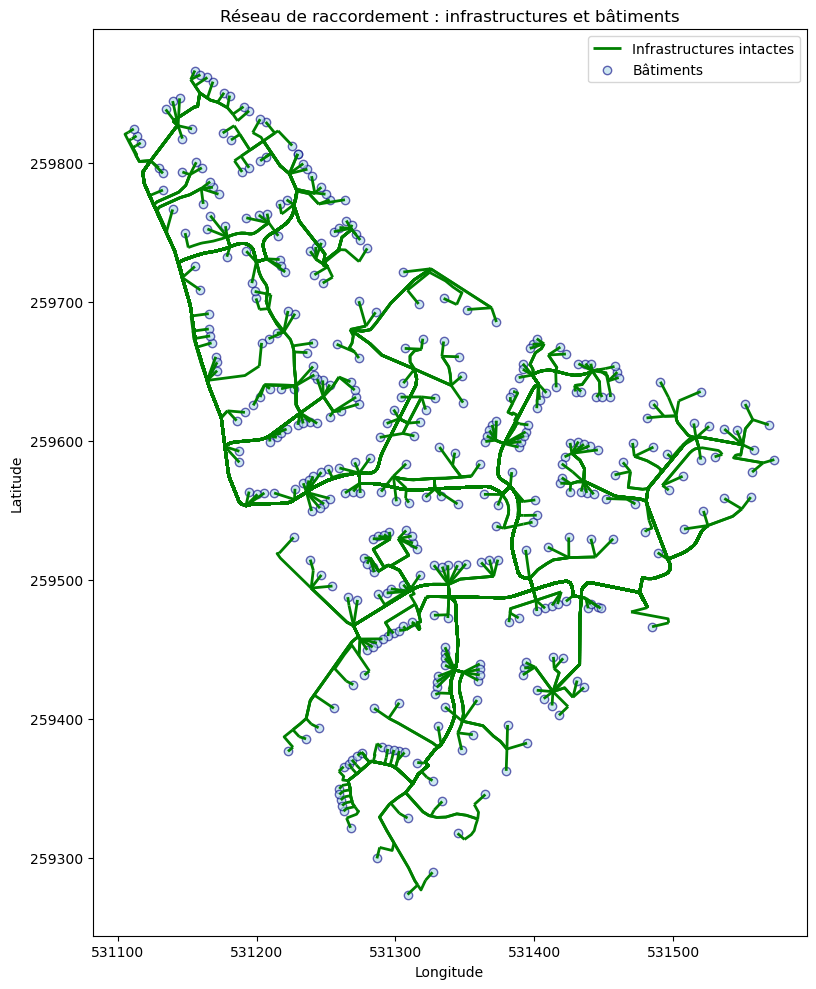

Carte fusionnée sauvegardée : 'reseau_fusionne.png'



In [207]:
infra_merged = visualiser_reseau_fusionne(batiments_gdf, infrastructures_gdf, df_csv)

###6. Rapport

In [ ]:
## Rédigez un rapport expliquant votre méthodologie, votre métrique de priorisation, et le plan de raccordement proposé.
## Justifiez vos choix et démontrez comment votre plan atteint l'objectif de maximisation des prises raccordées et de minimisation des coûts.


##Livraison Attendue

Un rapport détaillé incluant :

*   Une description de votre métrique de priorisation.
*   Le plan de raccordement des bâtiments avec l'ordre de priorité.
*   Une analyse des coûts et des bénéfices de votre planification.
*   Des cartes issues des shapefiles illustrant le plan de raccordement proposé.
*   Un résumé des défis rencontrés et des solutions apportées.

